In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos
from data_utils.dataset import (
    PhotoLabelDataset,
    stratified_split_dataset,
    train_transform,
    val_transform,
)
from model.resnet18 import Resnet18FineTuneModel
from model.utils import (
    get_device,
    train_model_single_epoch,
    validate_model_single_epoch,
    save_checkpoint,
    evaluate_model,
    plot_history,
)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preprocessing

In [2]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

Checking images: 100%|██████████| 200100/200100 [00:08<00:00, 22669.70it/s]


In [3]:
photos_df.label.value_counts()

label
food       96929
inside     37251
outside    12511
drink      10831
menu        1135
Name: count, dtype: int64

In [4]:
# Downsample labels to ensure balanced dataset
# min_images = photos_df.label.value_counts().min()
min_images = 10000
photos_df_balanced = (
    photos_df.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), min_images), random_state=42))
    .reset_index(drop=True)
)
photos_df_balanced.label.value_counts()

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_13305/3589507164.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), min_images), random_state=42))


label
drink      10000
food       10000
inside     10000
outside    10000
menu        1135
Name: count, dtype: int64

In [5]:
# Encode label for multiclass classification
label_encode_dict = {
    'inside': 0,
    'outside': 1,
    'food': 2,
    'drink': 3,
    'menu': 4
}
labe_decode_dict = {v: k for k, v in label_encode_dict.items()}

photos_df_balanced['encoded_label'] = photos_df_balanced['label'].map(label_encode_dict)

In [6]:
# Create dataset and loaders with data augmentations
label = 'encoded_label'

restaurant_dataset = PhotoLabelDataset(photos_df_balanced, photo_dir, label=label)
train_size = 0.85
val_size = 0.10

labels = photos_df_balanced[label].values
train_dataset, val_dataset, test_dataset = stratified_split_dataset(restaurant_dataset, labels, train_size, val_size, random_state=42)

train_dataset.transform = train_transform
val_dataset.transform = val_transform
test_dataset.transform = val_transform

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

for images, labels in val_loader:
    print("Images shape:", images.shape)  
    print("Labels shape:", labels.shape)
    break

Images shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


In [10]:
device = get_device()
model = Resnet18FineTuneModel(num_classes=5, unfreeze_layers=("layer4", "fc")).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scaler = torch.amp.GradScaler("cuda")
grad_clip = 1
ckpt_dir = "ckpt_label"

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}


# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=10):
    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss, train_accuracy = train_model_single_epoch(
            model, train_loader, criterion, optimizer, device, scaler, grad_clip
        )
        val_loss, val_accuracy = validate_model_single_epoch(model, val_loader, criterion, device)

        print(
            f"[Epoch {epoch}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f} | " f"Train Accuracy: {train_accuracy:.4f}",
            f"Val Loss: {val_loss:.4f} | " f"Val Accuracy: {val_accuracy:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        save_checkpoint(epoch, model, optimizer, history, ckpt_dir)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  

In [20]:
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=num_epochs)

Training: 100%|██████████| 547/547 [01:36<00:00,  5.70it/s, loss=0.0458]


[Epoch 1/10] Train Loss: 0.2431 | Train Accuracy: 0.9148 Val Loss: 0.2033 | Val Accuracy: 0.9336
Model checkpoint saved at ckpt_label/ckpt_1


Training: 100%|██████████| 547/547 [01:30<00:00,  6.07it/s, loss=0.0489] 


[Epoch 2/10] Train Loss: 0.1411 | Train Accuracy: 0.9502 Val Loss: 0.1840 | Val Accuracy: 0.9383
Model checkpoint saved at ckpt_label/ckpt_2


Training: 100%|██████████| 547/547 [01:24<00:00,  6.48it/s, loss=0.79]   


[Epoch 3/10] Train Loss: 0.0913 | Train Accuracy: 0.9695 Val Loss: 0.2068 | Val Accuracy: 0.9390
Model checkpoint saved at ckpt_label/ckpt_3


Training: 100%|██████████| 547/547 [01:22<00:00,  6.65it/s, loss=0.00373]


[Epoch 4/10] Train Loss: 0.0611 | Train Accuracy: 0.9783 Val Loss: 0.2054 | Val Accuracy: 0.9421
Model checkpoint saved at ckpt_label/ckpt_4


Training: 100%|██████████| 547/547 [01:21<00:00,  6.72it/s, loss=0.047]  


[Epoch 5/10] Train Loss: 0.0413 | Train Accuracy: 0.9856 Val Loss: 0.2375 | Val Accuracy: 0.9395
Model checkpoint saved at ckpt_label/ckpt_5


Training: 100%|██████████| 547/547 [01:21<00:00,  6.74it/s, loss=0.115]   


[Epoch 6/10] Train Loss: 0.0326 | Train Accuracy: 0.9890 Val Loss: 0.2686 | Val Accuracy: 0.9378
Model checkpoint saved at ckpt_label/ckpt_6


Training: 100%|██████████| 547/547 [01:21<00:00,  6.73it/s, loss=0.211]   


[Epoch 7/10] Train Loss: 0.0280 | Train Accuracy: 0.9911 Val Loss: 0.2440 | Val Accuracy: 0.9475
Model checkpoint saved at ckpt_label/ckpt_7


Training: 100%|██████████| 547/547 [01:22<00:00,  6.66it/s, loss=0.132]   


[Epoch 8/10] Train Loss: 0.0268 | Train Accuracy: 0.9908 Val Loss: 0.2933 | Val Accuracy: 0.9409
Model checkpoint saved at ckpt_label/ckpt_8


Training: 100%|██████████| 547/547 [01:28<00:00,  6.16it/s, loss=0.00273] 


[Epoch 9/10] Train Loss: 0.0220 | Train Accuracy: 0.9924 Val Loss: 0.2609 | Val Accuracy: 0.9441
Model checkpoint saved at ckpt_label/ckpt_9


Training: 100%|██████████| 547/547 [01:32<00:00,  5.93it/s, loss=0.0269]  


[Epoch 10/10] Train Loss: 0.0164 | Train Accuracy: 0.9946 Val Loss: 0.2928 | Val Accuracy: 0.9451
Model checkpoint saved at ckpt_label/ckpt_10


### Model evaluation

In [11]:
ckpt = torch.load(f"{base_dir}saved_models/label_classification/ckpt_best")
model = Resnet18FineTuneModel(num_classes=5)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

Resnet18FineTuneModel(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [12]:
evaluate_model(model, train_loader, device, class_names=label_encode_dict.keys())

Classification Report:
              precision    recall  f1-score   support

      inside       0.95      0.99      0.97      8500
     outside       0.98      0.98      0.98      8500
        food       0.99      0.98      0.99      8500
       drink       0.99      0.97      0.98      8500
        menu       0.99      0.94      0.96       964

    accuracy                           0.98     34964
   macro avg       0.98      0.97      0.98     34964
weighted avg       0.98      0.98      0.98     34964



In [13]:
evaluate_model(model, test_loader, device, class_names=label_encode_dict.keys())

Classification Report:
              precision    recall  f1-score   support

      inside       0.89      0.97      0.93       500
     outside       0.97      0.96      0.97       500
        food       0.98      0.97      0.98       500
       drink       0.98      0.93      0.95       500
        menu       0.98      0.86      0.92        57

    accuracy                           0.95      2057
   macro avg       0.96      0.94      0.95      2057
weighted avg       0.96      0.95      0.95      2057



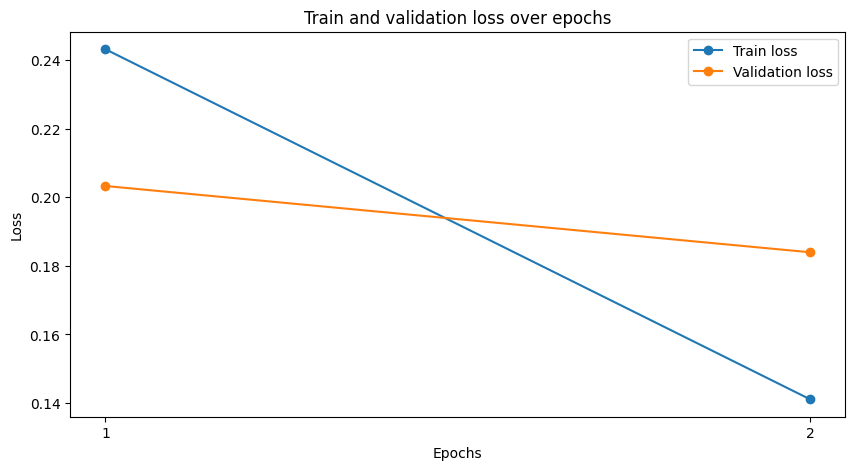

In [13]:
plot_history(ckpt['history'], 'loss')